In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import numpy as np
from tqdm import trange
import os 
import librosa
import matplotlib.pyplot as plt 
import tensorflow as tf
import itertools
import glob
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.backend import one_hot
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Add
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import PReLU
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import GlobalMaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix
from collections import OrderedDict
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras import models
from keras import layers

Using TensorFlow backend.


In [0]:
with np.load('/content/drive/My Drive/DT2119 project/data/mfcc_with_labels.npz',allow_pickle=True) as data:
    X = data['MFCC']
    y = data['labels']

In [0]:
def shuffle(X,Y):
  index = np.random.permutation(X.shape[0])
  Y = np.array(Y)
  return X[index],Y[index]

In [0]:
X, Y = shuffle(X,y)
N = X.shape[0]
X_train,Y_train = X[:3*N//5],Y[:3*N//5]
X_val,Y_val = X[3*N//5:4*N//5],Y[3*N//5:4*N//5]
X_test,Y_test = X[4*N//5:],Y[4*N//5:]
print(X_train.shape,Y_train.shape)

(600, 20, 1290) (600, 10)


In [0]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_val = scaler.transform(X_val.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

In [0]:
X_train.shape

(600, 20, 1290)

In [0]:
X_val.shape

(200, 20, 1290)

In [0]:
X_test.shape

(200, 20, 1290)

In [0]:
def conv(x, n_kernel, pool_size=(2, 2)):
    x = Conv2D(n_kernel, (3, 3), strides=(1, 1), padding='same',data_format="channels_last")(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=pool_size, strides=pool_size)(x)
    x = Dropout(0.25)(x)
    return x

In [0]:
def get_model(input_dim,output_dim,penalty):
    IN = Input(shape=(input_dim[0],input_dim[1],1))
    x = conv(IN, 16)
    x = conv(x, 32)
    x = conv(x, 64)
   # x = conv(x, 128)
    x = Flatten()(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu', 
              kernel_regularizer=tf.keras.regularizers.l2(penalty))(x)
    x = Dropout(0.25)(x)
    pred = Dense(output_dim, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(penalty))(x)
    model = Model(inputs=IN, outputs=pred)
    return model

In [0]:
model = get_model(X_train[-1].shape,10,1e-4) # -------------------Changed 
model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])
print(model.summary())
model.save('/content/drive/My Drive/cnn_2d.h5')

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 20, 1290, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 20, 1290, 16)      160       
_________________________________________________________________
activation (Activation)      (None, 20, 1290, 16)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 10, 645, 16)       0         
_________________________________________________________________
dropout (Dropout)            (None, 10, 645, 16)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 10, 645, 32)       4640      
_________________________________________________________________
activation_1 (Activation)    (None, 10, 645, 32)       0     

In [0]:
history = model.fit(X_train, Y_train,
                    batch_size=32,
                    epochs=40,
                    validation_data=(X_val, Y_val))

Epoch 1/40
19/19 [==============================] - 1s 42ms/step - loss: 3.1748 - accuracy: 0.1217 - val_loss: 2.3893 - val_accuracy: 0.1800
Epoch 2/40
19/19 [==============================] - 0s 23ms/step - loss: 2.3064 - accuracy: 0.1267 - val_loss: 2.2576 - val_accuracy: 0.2000
Epoch 3/40
19/19 [==============================] - 0s 22ms/step - loss: 2.1129 - accuracy: 0.2200 - val_loss: 2.0206 - val_accuracy: 0.3050
Epoch 4/40
19/19 [==============================] - 0s 23ms/step - loss: 1.9589 - accuracy: 0.3083 - val_loss: 1.9157 - val_accuracy: 0.3900
Epoch 5/40
19/19 [==============================] - 0s 23ms/step - loss: 1.7895 - accuracy: 0.4200 - val_loss: 1.7745 - val_accuracy: 0.4450
Epoch 6/40
19/19 [==============================] - 0s 22ms/step - loss: 1.7145 - accuracy: 0.4200 - val_loss: 1.6038 - val_accuracy: 0.4500
Epoch 7/40
19/19 [==============================] - 0s 23ms/step - loss: 1.4941 - accuracy: 0.5067 - val_loss: 1.6311 - val_accuracy: 0.4700
Epoch 8/40
19

In [0]:
model.evaluate(X_test, Y_test)

7/7 [==============================] - 0s 7ms/step - loss: 2.1941 - accuracy: 0.5150


[2.194122076034546, 0.5149999856948853]

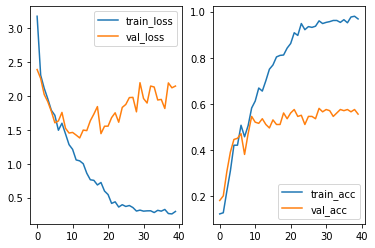

In [0]:
fig,ax = plt.subplots(ncols=2)
#fig.suptitle("epochs=%d  $\lambda$=%f lr=%f batch_size=%d"%(epochs,self.lamda,lr,batch_size))
ax[0].plot(history.history['loss'],label='train_loss')
ax[0].plot(history.history['val_loss'],label='val_loss')
ax[0].legend()
ax[1].plot(history.history['accuracy'],label='train_acc')
ax[1].plot(history.history['val_accuracy'],label='val_acc')
ax[1].legend()
plt.show()

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [0]:
preds = np.argmax(model.predict(X_test), axis = 1)
y_orig = np.argmax(Y_test, axis = 1)
cm = confusion_matrix(preds, y_orig)

Normalized confusion matrix


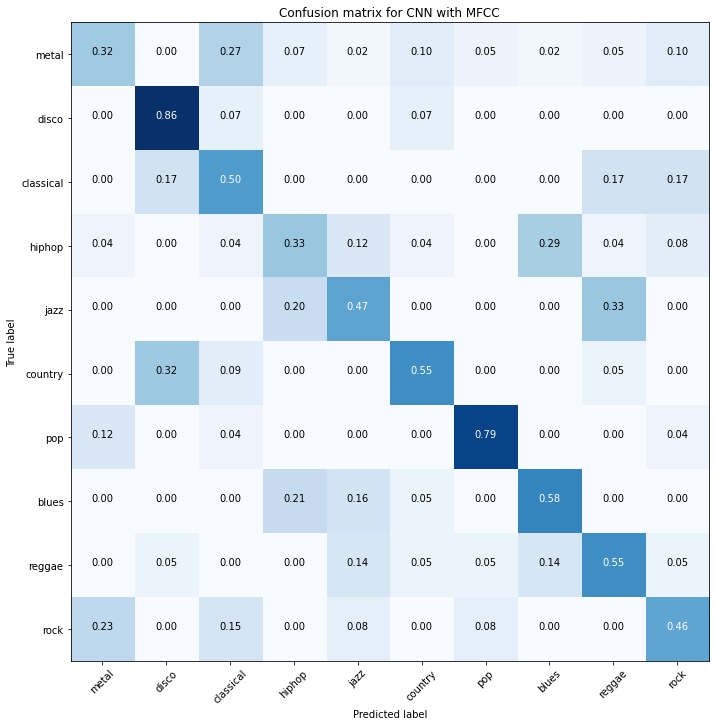

In [0]:
genres = {'metal': 0, 'disco': 1, 'classical': 2, 'hiphop': 3, 'jazz': 4, 
          'country': 5, 'pop': 6, 'blues': 7, 'reggae': 8, 'rock': 9}
keys = OrderedDict(sorted(genres.items(), key=lambda t: t[1])).keys()

plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, keys, title= 'Confusion matrix for CNN with MFCC', normalize=True)

In [0]:
def get_model_1(input_dim,output_dim,penalty):
    IN = Input(shape=(input_dim[0],input_dim[1],1))
    x = conv(IN, 16)
    #x = conv(x, 32)
    #x = conv(x, 64)
    #x = conv(x, 128)
    x = Flatten()(x)
    x = Dropout(0.5)(x)
    x = Dense(512, activation='relu', 
              kernel_regularizer=tf.keras.regularizers.l2(penalty))(x)
    x = Dropout(0.25)(x)
    pred = Dense(output_dim, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(penalty))(x)
    model = Model(inputs=IN, outputs=pred)
    return model

In [0]:
model1.reset_states() 
model1 = get_model_1(X_train[-1].shape,10,1e-4) # -------------------Changed 
model1.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])
print(model1.summary())
model1.save('/content/drive/My Drive/cnn_2d1.h5')

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 20, 1290, 1)]     0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 20, 1290, 16)      160       
_________________________________________________________________
activation_11 (Activation)   (None, 20, 1290, 16)      0         
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 10, 645, 16)       0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 10, 645, 16)       0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 103200)            0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 103200)            0   

In [0]:
history1 = model1.fit(X_train, Y_train,
                    batch_size=32,
                    epochs=40,
                    validation_data=(X_val, Y_val))

Epoch 1/40
19/19 [==============================] - 1s 30ms/step - loss: 18.6840 - accuracy: 0.1500 - val_loss: 3.3809 - val_accuracy: 0.1850
Epoch 2/40
19/19 [==============================] - 0s 22ms/step - loss: 2.4737 - accuracy: 0.2683 - val_loss: 1.9781 - val_accuracy: 0.3550
Epoch 3/40
19/19 [==============================] - 0s 21ms/step - loss: 1.8990 - accuracy: 0.4117 - val_loss: 1.8690 - val_accuracy: 0.3850
Epoch 4/40
19/19 [==============================] - 0s 22ms/step - loss: 1.6880 - accuracy: 0.4733 - val_loss: 1.7453 - val_accuracy: 0.4850
Epoch 5/40
19/19 [==============================] - 0s 22ms/step - loss: 1.5602 - accuracy: 0.5083 - val_loss: 1.6476 - val_accuracy: 0.5200
Epoch 6/40
19/19 [==============================] - 0s 22ms/step - loss: 1.4041 - accuracy: 0.5817 - val_loss: 1.5373 - val_accuracy: 0.5550
Epoch 7/40
19/19 [==============================] - 0s 21ms/step - loss: 1.2159 - accuracy: 0.6583 - val_loss: 1.5193 - val_accuracy: 0.5400
Epoch 8/40
1

In [0]:
model1.evaluate(X_test, Y_test)

7/7 [==============================] - 0s 7ms/step - loss: 1.6934 - accuracy: 0.5550


[1.693416714668274, 0.5550000071525574]

modeling with mfcc+delta

In [0]:
with np.load('/content/drive/My Drive/DT2119 project/data/mfcc_delta_with_labels.npz',allow_pickle=True) as data:
    X = data['MFCC']
    y = data['labels']

In [0]:
X, Y = shuffle(X,y)
N = X.shape[0]
X_train,Y_train = X[:3*N//5],Y[:3*N//5]
X_val,Y_val = X[3*N//5:4*N//5],Y[3*N//5:4*N//5]
X_test,Y_test = X[4*N//5:],Y[4*N//5:]
print(X_train.shape,Y_train.shape)

(600, 60, 1290) (600, 10)


In [0]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_val = scaler.transform(X_val.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

In [0]:
model.reset_states() 
model = get_model(X_train[-1].shape,10,1e-4) # -------------------Changed 
model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])
print(model.summary())
model.save('/content/drive/My Drive/cnn_delta_2d.h5')

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 60, 1290, 1)]     0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 60, 1290, 16)      160       
_________________________________________________________________
activation_3 (Activation)    (None, 60, 1290, 16)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 30, 645, 16)       0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 30, 645, 16)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 30, 645, 32)       4640      
_________________________________________________________________
activation_4 (Activation)    (None, 30, 645, 32)       0   

In [0]:
history = model.fit(X_train, Y_train,
                    batch_size=32,
                    epochs=40,
                    validation_data=(X_val, Y_val))

Epoch 1/40
19/19 [==============================] - 2s 89ms/step - loss: 5.4814 - accuracy: 0.1200 - val_loss: 2.4596 - val_accuracy: 0.1050
Epoch 2/40
19/19 [==============================] - 1s 63ms/step - loss: 2.4468 - accuracy: 0.1450 - val_loss: 2.4617 - val_accuracy: 0.1350
Epoch 3/40
19/19 [==============================] - 1s 64ms/step - loss: 2.3573 - accuracy: 0.1100 - val_loss: 2.3323 - val_accuracy: 0.1950
Epoch 4/40
19/19 [==============================] - 1s 66ms/step - loss: 2.2230 - accuracy: 0.1950 - val_loss: 2.1646 - val_accuracy: 0.2150
Epoch 5/40
19/19 [==============================] - 1s 65ms/step - loss: 1.9921 - accuracy: 0.3233 - val_loss: 1.9163 - val_accuracy: 0.3450
Epoch 6/40
19/19 [==============================] - 1s 65ms/step - loss: 1.7719 - accuracy: 0.3683 - val_loss: 1.7027 - val_accuracy: 0.3450
Epoch 7/40
19/19 [==============================] - 1s 65ms/step - loss: 1.6294 - accuracy: 0.4300 - val_loss: 1.6414 - val_accuracy: 0.4150
Epoch 8/40
19

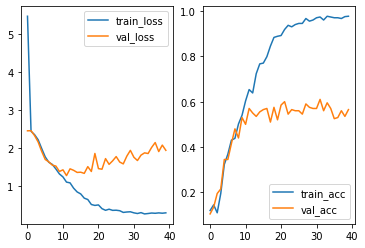

In [0]:
fig,ax = plt.subplots(ncols=2)
#fig.suptitle("epochs=%d  $\lambda$=%f lr=%f batch_size=%d"%(epochs,self.lamda,lr,batch_size))
ax[0].plot(history.history['loss'],label='train_loss')
ax[0].plot(history.history['val_loss'],label='val_loss')
ax[0].legend()
ax[1].plot(history.history['accuracy'],label='train_acc')
ax[1].plot(history.history['val_accuracy'],label='val_acc')
ax[1].legend()
plt.show()

In [0]:
preds = np.argmax(model.predict(X_test), axis = 1)
y_orig = np.argmax(Y_test, axis = 1)
cm = confusion_matrix(preds, y_orig)

Normalized confusion matrix


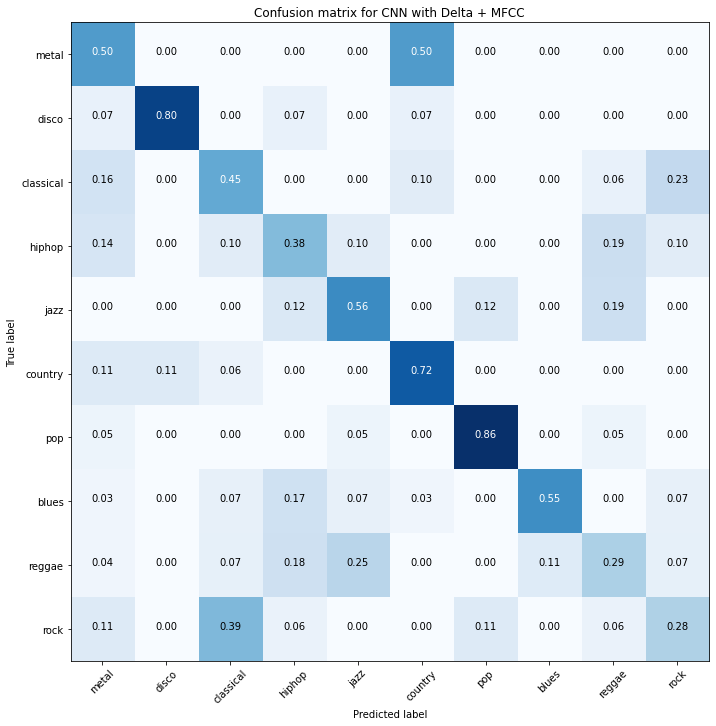

In [0]:
genres = {'metal': 0, 'disco': 1, 'classical': 2, 'hiphop': 3, 'jazz': 4, 
          'country': 5, 'pop': 6, 'blues': 7, 'reggae': 8, 'rock': 9}
keys = OrderedDict(sorted(genres.items(), key=lambda t: t[1])).keys()

plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, keys,  title= 'Confusion matrix for CNN with Delta + MFCC', normalize=True)

In [0]:
model.evaluate(X_test, Y_test)

7/7 [==============================] - 0s 17ms/step - loss: 2.1664 - accuracy: 0.5250


[2.166363000869751, 0.5249999761581421]

modeling with dynamic MFCC

In [0]:
with np.load('/content/drive/My Drive/DT2119 project/data/dynamic_mfcc_with_labels.npz',allow_pickle=True) as data:
    X = data['MFCC']
    y = data['labels']

In [0]:
X.shape

(1000, 140, 1290)

In [0]:
X, Y = shuffle(X,y)
N = X.shape[0]
X_train,Y_train = X[:3*N//5],Y[:3*N//5]
X_val,Y_val = X[3*N//5:4*N//5],Y[3*N//5:4*N//5]
X_test,Y_test = X[4*N//5:],Y[4*N//5:]
print(X_train.shape,Y_train.shape)

(600, 140, 1290) (600, 10)


In [0]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_val = scaler.transform(X_val.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

In [0]:
model = get_model(X_train[-1].shape,10,1e-4) # -------------------Changed 
model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])
print(model.summary())
model.save('/content/drive/My Drive/cnn_dynamic_2d.h5')

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 140, 1290, 1)]    0         
_________________________________________________________________
conv2d (Conv2D)              (None, 140, 1290, 16)     160       
_________________________________________________________________
activation (Activation)      (None, 140, 1290, 16)     0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 70, 645, 16)       0         
_________________________________________________________________
dropout (Dropout)            (None, 70, 645, 16)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 70, 645, 32)       4640      
_________________________________________________________________
activation_1 (Activation)    (None, 70, 645, 32)       0     

In [0]:
history = model.fit(X_train, Y_train,
                    batch_size=32,
                    epochs=40,
                    validation_data=(X_val, Y_val))

Epoch 1/40
19/19 [==============================] - 2s 110ms/step - loss: 13.9238 - accuracy: 0.1200 - val_loss: 2.5789 - val_accuracy: 0.0650
Epoch 2/40
19/19 [==============================] - 2s 88ms/step - loss: 2.5974 - accuracy: 0.1333 - val_loss: 2.6143 - val_accuracy: 0.0900
Epoch 3/40
19/19 [==============================] - 2s 88ms/step - loss: 2.5652 - accuracy: 0.1250 - val_loss: 2.5090 - val_accuracy: 0.1600
Epoch 4/40
19/19 [==============================] - 2s 90ms/step - loss: 2.4401 - accuracy: 0.1833 - val_loss: 2.3841 - val_accuracy: 0.2350
Epoch 5/40
19/19 [==============================] - 2s 88ms/step - loss: 2.2482 - accuracy: 0.2667 - val_loss: 2.2507 - val_accuracy: 0.2600
Epoch 6/40
19/19 [==============================] - 2s 89ms/step - loss: 2.1619 - accuracy: 0.2833 - val_loss: 2.2694 - val_accuracy: 0.2800
Epoch 7/40
19/19 [==============================] - 2s 89ms/step - loss: 2.0658 - accuracy: 0.3250 - val_loss: 2.1233 - val_accuracy: 0.3100
Epoch 8/40


In [0]:
model.evaluate(X_test, Y_test)

7/7 [==============================] - 0s 21ms/step - loss: 2.4670 - accuracy: 0.5050


[2.4669692516326904, 0.5049999952316284]

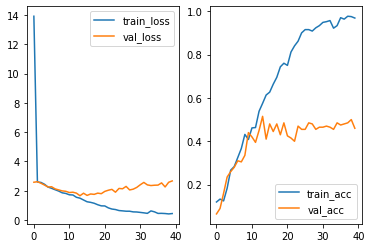

In [0]:
fig,ax = plt.subplots(ncols=2)
#fig.suptitle("epochs=%d  $\lambda$=%f lr=%f batch_size=%d"%(epochs,self.lamda,lr,batch_size))
ax[0].plot(history.history['loss'],label='train_loss')
ax[0].plot(history.history['val_loss'],label='val_loss')
ax[0].legend()
ax[1].plot(history.history['accuracy'],label='train_acc')
ax[1].plot(history.history['val_accuracy'],label='val_acc')
ax[1].legend()
plt.show()

In [0]:
preds = np.argmax(model.predict(X_test), axis = 1)
y_orig = np.argmax(Y_test, axis = 1)
cm = confusion_matrix(preds, y_orig)

Normalized confusion matrix


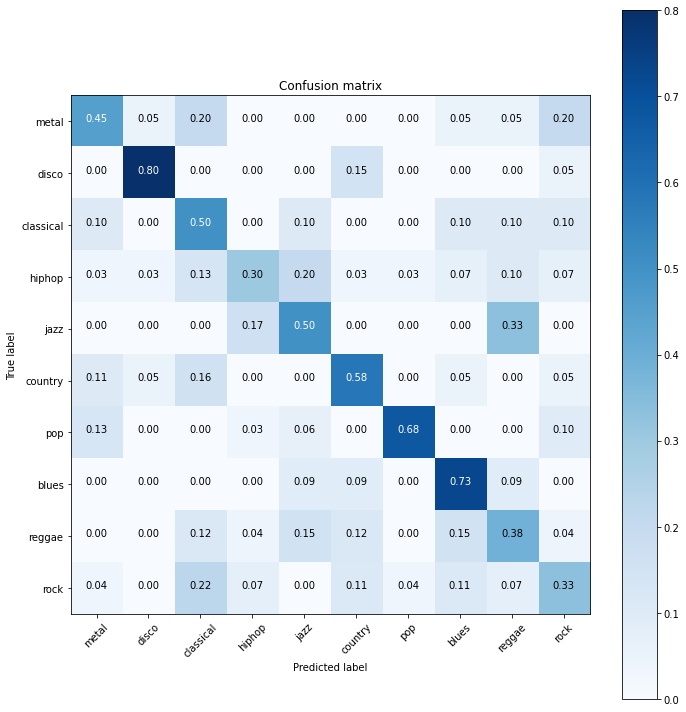

In [0]:
genres = {'metal': 0, 'disco': 1, 'classical': 2, 'hiphop': 3, 'jazz': 4, 
          'country': 5, 'pop': 6, 'blues': 7, 'reggae': 8, 'rock': 9}
keys = OrderedDict(sorted(genres.items(), key=lambda t: t[1])).keys()

plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, keys, normalize=True)

In [0]:
with np.load('/content/drive/My Drive/DT2119 project/data/mfcc_with_labels.npz',allow_pickle=True) as data:
    X = data['MFCC']
    y = data['labels']

In [0]:
with np.load('/content/drive/My Drive/DT2119 project/data/mfcc_delta_with_labels.npz',allow_pickle=True) as data:
    X = data['MFCC']
    y = data['labels']

In [0]:
X_f = np.ndarray.flatten(X).reshape(1000,-1)
X_train, X_test, y_train, y_test = train_test_split(X_f, y, test_size=0.2)

In [0]:
X_f.shape

(1000, 25800)

In [0]:
scaler = StandardScaler()
scaler.fit(np.array(X_train, dtype = float))
scaler.transform(X_train)
scaler.transform(X_test)

array([[ 0.9407464 ,  0.82672924,  0.6206129 , ..., -0.6875567 ,
        -0.03270151,  0.7163884 ],
       [ 0.7775396 ,  0.94533306,  0.7754519 , ...,  1.3968894 ,
         0.40760553,  0.41068536],
       [-1.6978501 , -1.1447616 , -0.7130767 , ...,  0.9055441 ,
         1.6526589 ,  1.6550374 ],
       ...,
       [ 1.2232778 ,  1.1247876 ,  0.97234184, ..., -1.6191126 ,
        -1.4485176 , -1.444392  ],
       [-0.2413047 ,  0.0353111 ,  0.33852684, ...,  0.33801585,
         1.0690638 ,  1.0717709 ],
       [-2.2956626 , -2.3028362 , -2.1886601 , ..., -0.53003746,
         0.19239421,  0.19559526]], dtype=float32)

In [0]:
from keras import regularizers

model = models.Sequential()
#model.add(layers.Dropout(0.25))
model.add(layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],), 
                       kernel_regularizer=regularizers.l2(0.001)))
       
model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)))

model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)))

model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)))

model.add(layers.Dense(10, activation='softmax'))

In [0]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])
history = model.fit(X_train,
                    y_train,
                    epochs=20,
                    batch_size=32,
                    validation_split=0.25)
model.evaluate(X_test, y_test)

Train on 600 samples, validate on 200 samples
Epoch 1/20
600/600 [==============================] - 0s 828us/step - loss: 175.6312 - acc: 0.1583 - val_loss: 106.9598 - val_acc: 0.2000
Epoch 2/20
600/600 [==============================] - 0s 503us/step - loss: 53.3320 - acc: 0.3100 - val_loss: 32.2675 - val_acc: 0.3150
Epoch 3/20
600/600 [==============================] - 0s 526us/step - loss: 17.2654 - acc: 0.4683 - val_loss: 17.3313 - val_acc: 0.3150
Epoch 4/20
600/600 [==============================] - 0s 523us/step - loss: 7.1185 - acc: 0.6383 - val_loss: 12.5080 - val_acc: 0.3650
Epoch 5/20
600/600 [==============================] - 0s 518us/step - loss: 3.7829 - acc: 0.7900 - val_loss: 13.2321 - val_acc: 0.3850
Epoch 6/20
600/600 [==============================] - 0s 521us/step - loss: 3.6559 - acc: 0.7917 - val_loss: 11.4498 - val_acc: 0.4100
Epoch 7/20
600/600 [==============================] - 0s 517us/step - loss: 2.5025 - acc: 0.8667 - val_loss: 9.7925 - val_acc: 0.4550
Epoch

[7.443049545288086, 0.49000000953674316]

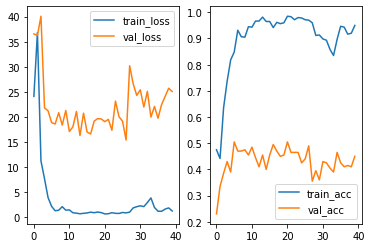

In [0]:
fig,ax = plt.subplots(ncols=2)

ax[0].plot(history.history['loss'],label='train_loss')
ax[0].plot(history.history['val_loss'],label='val_loss')
ax[0].legend()
ax[1].plot(history.history['acc'],label='train_acc')
ax[1].plot(history.history['val_acc'],label='val_acc')
ax[1].legend()
plt.show()

In [0]:
with np.load('/content/drive/My Drive/DT2119 project/data/mfcc_delta_with_labels.npz',allow_pickle=True) as data:
    X = data['MFCC']
    y = data['labels']